In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization 

In [2]:
!pip install seaborn

In [3]:
TRAIN_DIR =  'D:/DL_Project/Emotion/train/train/'
TEST_DIR =  'D:/DL_Project/Emotion/test/test/'

# TRAIN_DIR =  r'train\train'
# TEST_DIR =  r'test\test'

In [4]:
'''Load image data from the given directory containing the image data'''
def load_imgdata(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory + label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed" )

    return image_paths, labels #It returns A list of image paths and a list of corresponding labels

In [5]:
train = pd.DataFrame()

# Load image data into the DataFrame
train['image'], train['label'] = load_imgdata(TRAIN_DIR)

# Shuffling of the training data
train = train.sample(frac = 1).reset_index(drop = True)

train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,D:/DL_Project/Emotion/train/train/fear\Trainin...,fear
1,D:/DL_Project/Emotion/train/train/sad\Training...,sad
2,D:/DL_Project/Emotion/train/train/fear\Trainin...,fear
3,D:/DL_Project/Emotion/train/train/happy\Traini...,happy
4,D:/DL_Project/Emotion/train/train/neutral\Trai...,neutral


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = load_imgdata(TEST_DIR)

test.head()


angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,D:/DL_Project/Emotion/test/test/angry\PrivateT...,angry
1,D:/DL_Project/Emotion/test/test/angry\PrivateT...,angry
2,D:/DL_Project/Emotion/test/test/angry\PrivateT...,angry
3,D:/DL_Project/Emotion/test/test/angry\PrivateT...,angry
4,D:/DL_Project/Emotion/test/test/angry\PrivateT...,angry


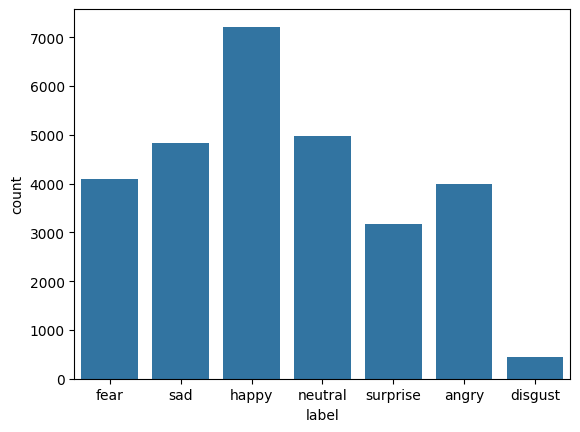

In [7]:
sns.countplot(data=train, x='label')
plt.show()

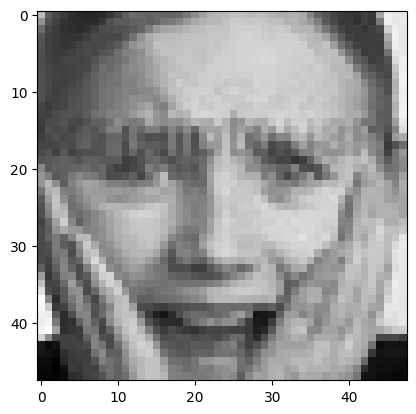

In [8]:
from PIL import Image

img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray')

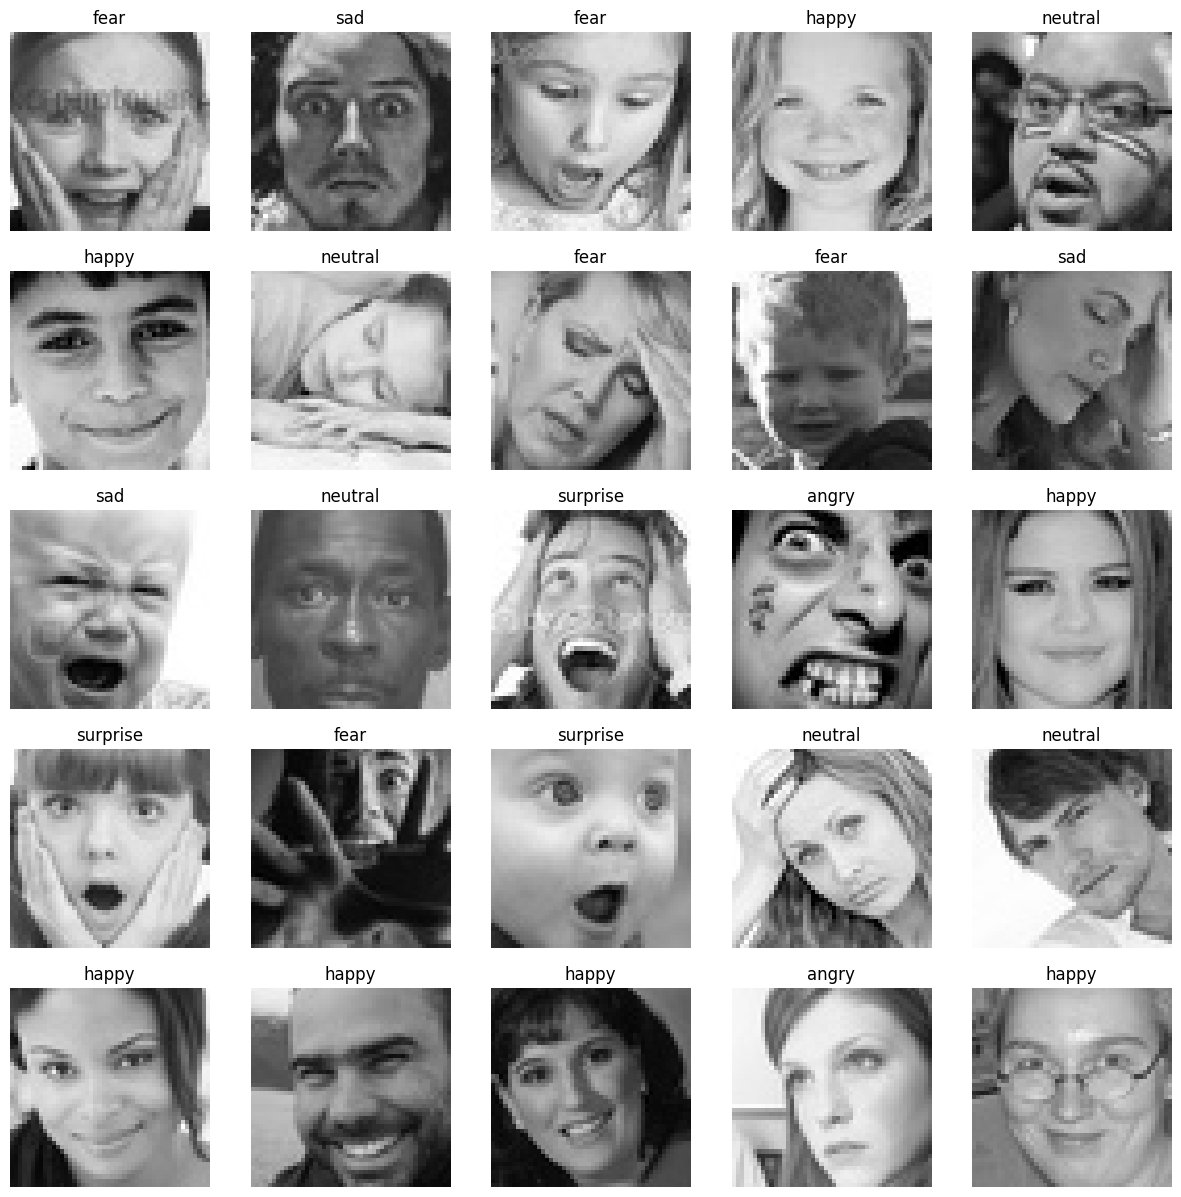

In [9]:
#Plot a grid of images and their corresponding labels.
plt.figure(figsize=(15,15))
files = train.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

In [10]:
def extract_features(images):
    features = []
    
    for file in tqdm(images):
        img = load_img(file, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    
    features = np.array(features).reshape(len(features),48,48,1)
    return features

In [11]:

# Extract features from the 'train' dataframe
feat_train = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
# Extract features from the 'test' images

feat_test = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
feat_train.shape

(28709, 48, 48, 1)

In [14]:
# Normalize the pixel values of the training & testing set
X_train = feat_train / 255.0
X_test = feat_test / 255.0

In [15]:
X_train.shape

(28709, 48, 48, 1)

In [16]:
from sklearn.preprocessing import LabelEncoder
import pickle
le = LabelEncoder()
y_train = le.fit_transform(train['label']) #Fit & transform the 'label' column of 'train' DataFrame
y_test = le.transform(test['label']) # Transform the 'label' column of 'test' DataFrame



# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(le, f)
# f.close()

In [17]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

In [18]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [19]:
cnn = Sequential()

#Convolutional Layer(s)
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.32))

# Flatten
cnn.add(Flatten())

#Fully-Connected Layer(s)
cnn.add(Dense(units=512,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Dense(units=512,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output Layer
cnn.add(Dense(units=7,activation='softmax'))

In [20]:
# Compiling the loss function, optimizer, and accuracy of the model
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
r = cnn.fit(x=X_train,y=y_train,batch_size=128,epochs=55,validation_data=(X_test,y_test))

Epoch 1/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 213s 927ms/step - accuracy: 0.2231 - loss: 2.2675 - val_accuracy: 0.2471 - val_loss: 3.1021
Epoch 2/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 208s 924ms/step - accuracy: 0.3998 - loss: 1.5851 - val_accuracy: 0.1690 - val_loss: 2.1218
Epoch 3/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 208s 922ms/step - accuracy: 0.4845 - loss: 1.3571 - val_accuracy: 0.4423 - val_loss: 1.3538
Epoch 4/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 209s 927ms/step - accuracy: 0.5430 - loss: 1.2153 - val_accuracy: 0.5560 - val_loss: 1.1663
Epoch 5/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 921ms/step - accuracy: 0.5730 - loss: 1.1287 - val_accuracy: 0.5698 - val_loss: 1.1430
Epoch 6/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 208s 924ms/step - accuracy: 0.5899 - loss: 1.0714 - val_accuracy: 0.5600 - val_loss: 1.1361
Epoch 7/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 920ms/step - accuracy: 0.6322 - loss: 0.9841 - val_accuracy: 0.5106 - val_loss: 1.3773
Epoch 8/55
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 919ms/step - accuracy: 0.6505 -

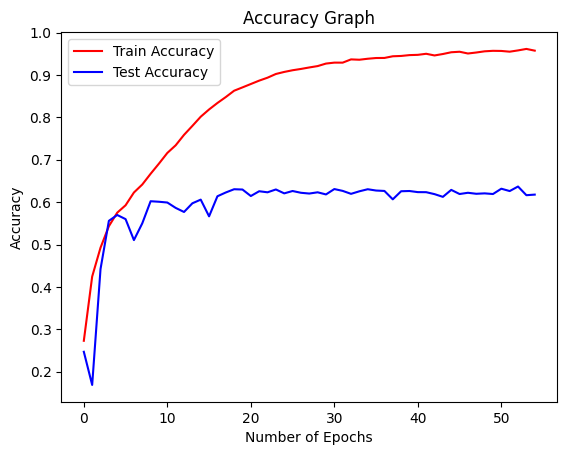

In [22]:
# Extracting accuracy and validation accuracy from history
accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Test Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

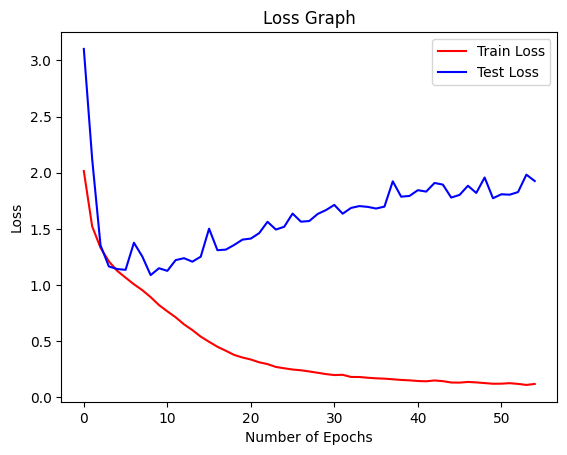

In [23]:
# Extracting loss and validation loss
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Test Loss')
plt.title('Loss Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

Original Output Label: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Predicted O/p Label: angry


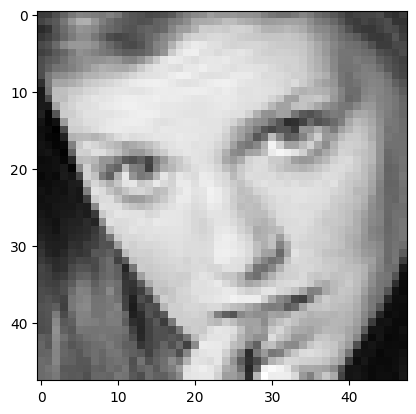

In [24]:
'''Get a random image label and make a prediction using the given CNN model'''
import random

img_indx = random.randint(0,len(test))
print("Original Output Label:", test['label'][img_indx])
pred = cnn.predict(X_test[img_indx].reshape(1,48,48,1))
predicted_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted O/p Label:", predicted_label)
plt.imshow(X_test[img_indx].reshape(48,48),cmap='gray')

In [28]:
# f=open('label_encoder1.pkl', 'wb') 
# pickle.dump(le,f)
# f.close()


In [ ]:
# # Load model
# from keras.models import load_model
# loaded_model = load_model('model.h5')